In [83]:
from cpymad.madx import Madx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls
from scipy.optimize import minimize as som

# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display


def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

In [92]:
def input_str(x):
    return '''
    
    CALL, FILE = "Optics_v7.str";
    CALL, FILE = "CRYRING_v7.1.0.seq";

    beam, particle = proton, sequence=cryring, pc = {};
    use, sequence=cryring;

    select, flag=twiss, column=apertype, aper_1, aper_2;
    twiss;
    '''.format(x)


# ! extend to dx/dkd !!
# replace with scalar function
def find_gradient(theta):
    
    kf0=0.5086546699
    kd0 =-0.6511149282
    
    delta = kf0/100
    k = kf0+delta

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};k0nl_YR01LB1={};
    twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};k0nl_YR01LB1={};
    twiss;'''.format(k,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]
    
#    print(np.array(xbpm-xbpm0)[0])
    vec = np.array(xbpm-xbpm0)/delta
    return vec

#    return np.linalg.norm(vec)
#    return np.sum(vec) # extention to k_d will be easier


def func(theta):

    kf0=0.5086546699
    kd0 =-0.6511149282
    
    delta = kf0/100
    
    kqfl = np.linspace(kf0-delta,kf0+delta, 5)
    bpm = []
    for k in kqfl:
        madx.input('''kqfl ={}; kqdl ={}; 
        k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};k0nl_YR01LB1={};
        twiss;'''.format(k,kd0,*theta));
        aux=madx.table.twiss.dframe()
        xbpm = aux[aux["keyword"]=="hmonitor"]["x"]
        bpm.append(xbpm)


    aux =np.transpose(bpm)
    metric = [np.max(x)-np.min(x) for x in aux]
    print('metric = {}'.format(np.mean(metric)))
    return metric

In [59]:
madx = Madx(stdout=False)

pc = np.sqrt(2*0.9382720813*50*10**(-6)) # Kin Energy 50 KeV
myStr0 = input_str(pc)

myStr1 = '''
addquaderr(dx_err,dy_err,quadname): macro = {
SELECT, FLAG=error, clear;
eoption, seed=2, add=false;
SELECT, FLAG=error, PATTERN="quadname";

EALIGN, DX:=dx_err, DY:=dy_err;
};'''




dxdy = np.random.normal(0.,0.001, 2*18)
myStr2 = '''

exec, addquaderr({},{},YR02QS1);
exec, addquaderr({},{},YR02QS2);
exec, addquaderr({},{},YR02QS3);

exec, addquaderr({},{},YR04QS1);
exec, addquaderr({},{},YR04QS2);
exec, addquaderr({},{},YR04QS3);

exec, addquaderr({},{},YR06QS1);
exec, addquaderr({},{},YR06QS2);
exec, addquaderr({},{},YR06QS3);

exec, addquaderr({},{},YR08QS1);
exec, addquaderr({},{},YR08QS2);
exec, addquaderr({},{},YR08QS3);

exec, addquaderr({},{},YR10QS1);
exec, addquaderr({},{},YR10QS2);
exec, addquaderr({},{},YR10QS3);

exec, addquaderr({},{},YR12QS1);
exec, addquaderr({},{},YR12QS2);
exec, addquaderr({},{},YR12QS3);

SELECT, FLAG = ERROR, FULL;
ESAVE, FILE = err.txt;

select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;
twiss;
'''.format(*dxdy)

madx.input(myStr0);
madx.input(myStr1);
madx.input(myStr2);
DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="hmonitor"]

In [60]:
theta = np.zeros(9)
theta[0] = np.random.normal(0,0.0001)

find_gradient(theta)

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

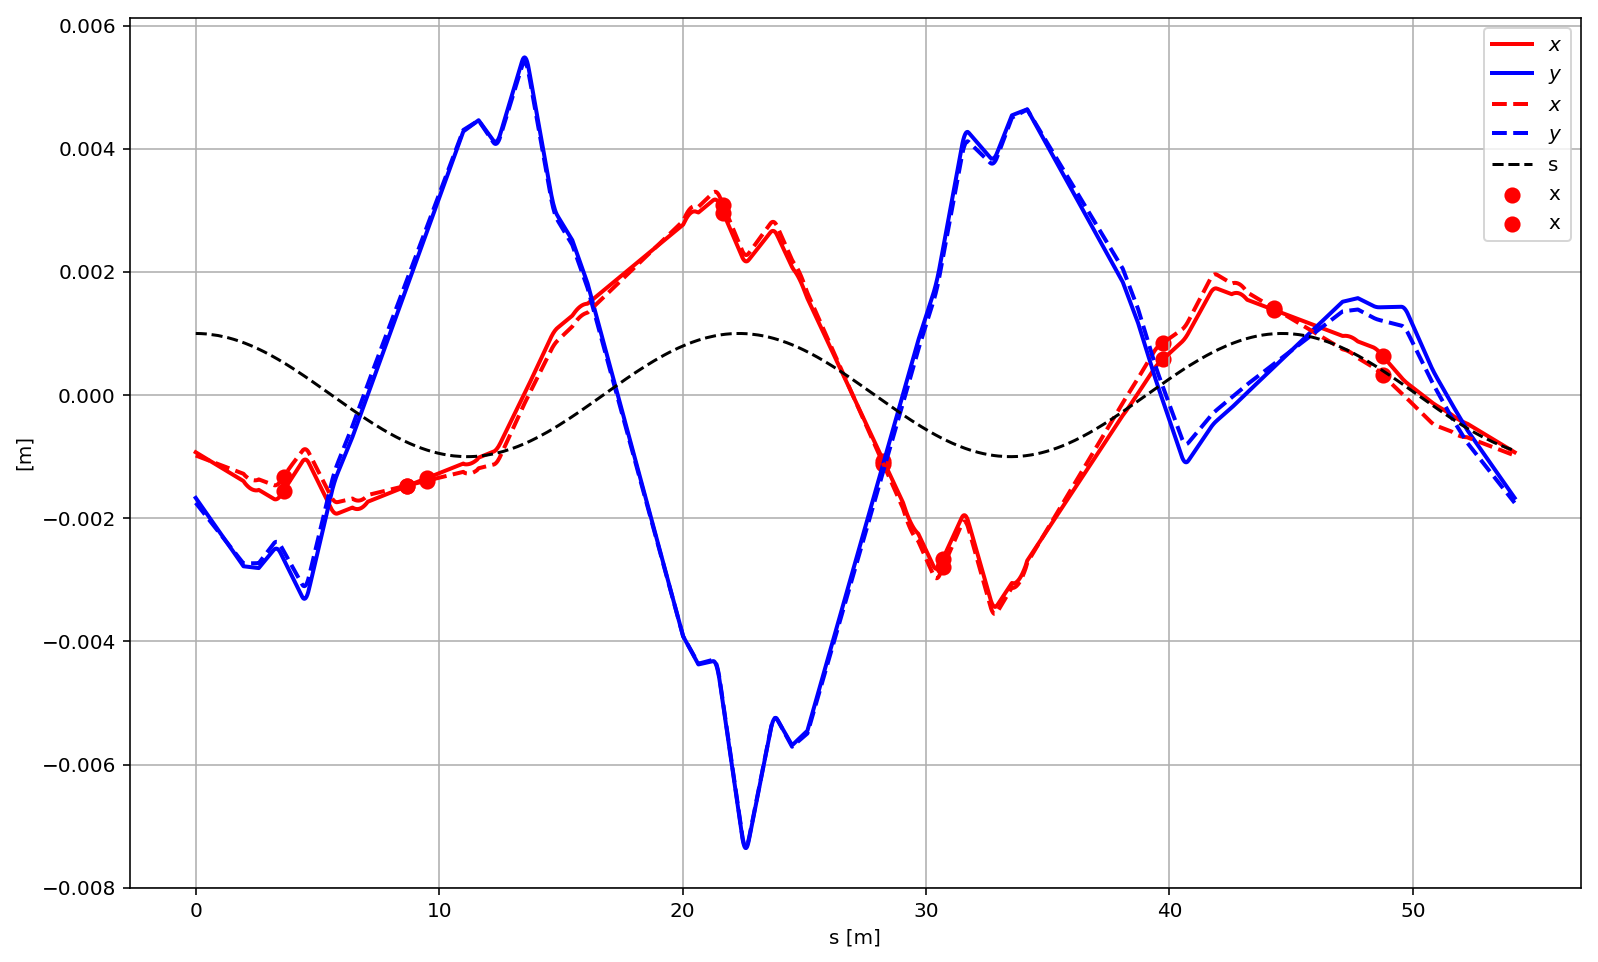

In [62]:
fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='$x$', lw=2)
plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50)

plt.plot(DF['s'],DF['x'],'r',ls="--", label='$x$', lw=2)
plt.plot(DF['s'],DF['y'],'b',ls="--", label='$y$', lw=2)

plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50)

plt.plot(DF['s'],0.001*np.cos(2*np.pi*2.42*DF['s']/54),'black',ls="--")

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()


In [17]:
theta = np.zeros(9)
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};k0nl_YR01LB1={};
twiss;'''.format(*theta));

kh = np.linspace(-0.0001,0.0001,10)
aux = []
for i in range(9):

    tmp = []
    theta = np.zeros(9)

    for th in kh:
        theta[i]=th
        g = find_gradient(theta)
        tmp.append(g)
    aux.append(tmp)
    


In [79]:
theta = np.zeros(9)
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};k0nl_YR01LB1={};
twiss;'''.format(*theta));

aux,tmp = [],[]
for i in range(100):
    theta = np.random.normal(0,0.001,9)
    g = find_gradient(theta)
    aux.append(g)    
    tmp.append(theta)
    


(-0.002978710016869819, 0.0029084386929504264)

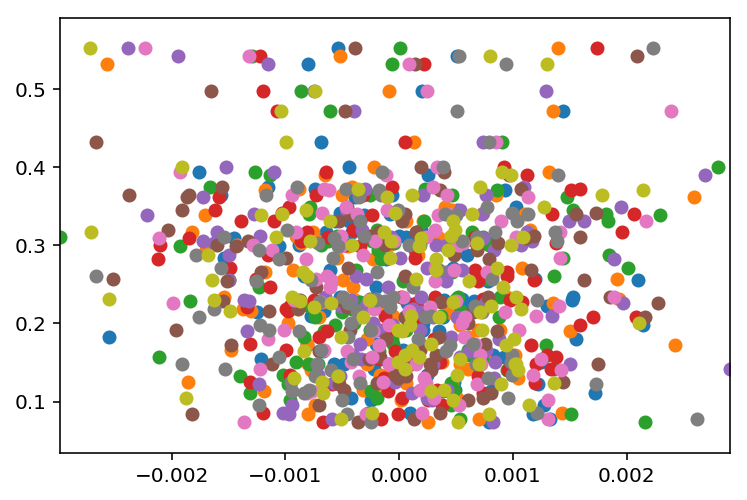

In [81]:
#plt.plot(1000*kh,aux)
[plt.scatter(np.transpose(tmp)[i], aux) for i in range(9)]
plt.xlim(np.min(tmp),np.max(tmp))
#plt.show()

#[plt.plot(1000*kh,a) for a in aux]

In [9]:
#tmp = np.transpose(aux)

#np.transpose([stats.linregress(a,kh)[0:2] for a in tmp] )

In [94]:


theta0 = np.zeros(9)
print(theta0)

# find zero dx/dkf gradient (theta = theta0) 
g0 = find_gradient(theta0)

#d_theta = 0.0001
d_theta = np.random.normal(0,0.0001)
print(d_theta)

corr = theta0[:]
kappa = []
for i in range(len(theta0)):
    corr[i] += d_theta
    g =find_gradient(corr)
    kappa.append((g-g0)/d_theta/len(theta0))
    
#print(kappa)
#vec = np.dot(np.linalg.inv(np.transpose(kappa)),-g0*len(theta0))
#vec = -np.dot(np.linalg.inv(kappa)/len(theta0),g0)


#theta = np.random.normal(0,0.0001,9)
#print(theta)

#aux = np.matmul(kappa,theta)/len(theta0)+g0
#aux = np.dot(kappa,theta)
#print(aux)


#g1 = find_gradient(theta)
#print(g1)
# works properly only close to zero

#vec = np.linalg.solve(kappa,-g0)
#print(vec)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.946951038777023e-05


In [110]:
def kappa_counter(theta0):

    g0 = find_gradient(theta0)

    d_theta = np.random.normal(0,0.0001)

    corr = theta0[:]
    kappa = []
    for i in range(len(theta0)):
        corr[i] += d_theta
        g =find_gradient(corr)
        kappa.append((g-g0)/d_theta/len(theta0))
        
    return np.array(kappa)


def real_fun(x, kappa):
    step = [0.0001 for a in x]
    aux = np.linalg.norm(np.matmul(kappa,x)/len(x)-step)
    return aux

theta = np.zeros(9)
arg = (kappa_counter(theta),)
vec0 = som(real_fun,x0=theta0, args=arg, method="COBYLA")

arg = (kappa_counter(vec0.x),)
vec1 = som(real_fun,x0=vec0.x, args=arg, method="COBYLA")

print(vec)

     fun: 0.00015778347560450615
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 73
  status: 1
 success: True
       x: array([-5.31769925e-05,  5.26053457e-05, -6.80750716e-05,  2.97361042e-05,
        1.16626820e-04,  1.30652039e-06, -9.14471283e-05, -1.06843473e-05,
       -3.52928236e-05])


In [111]:
madx.input('''kqfl =0.5086546699; kqdl =-0.6511149282; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k12kh ={};k0nl_YR01LB1={};
twiss;'''.format(*vec.x));

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

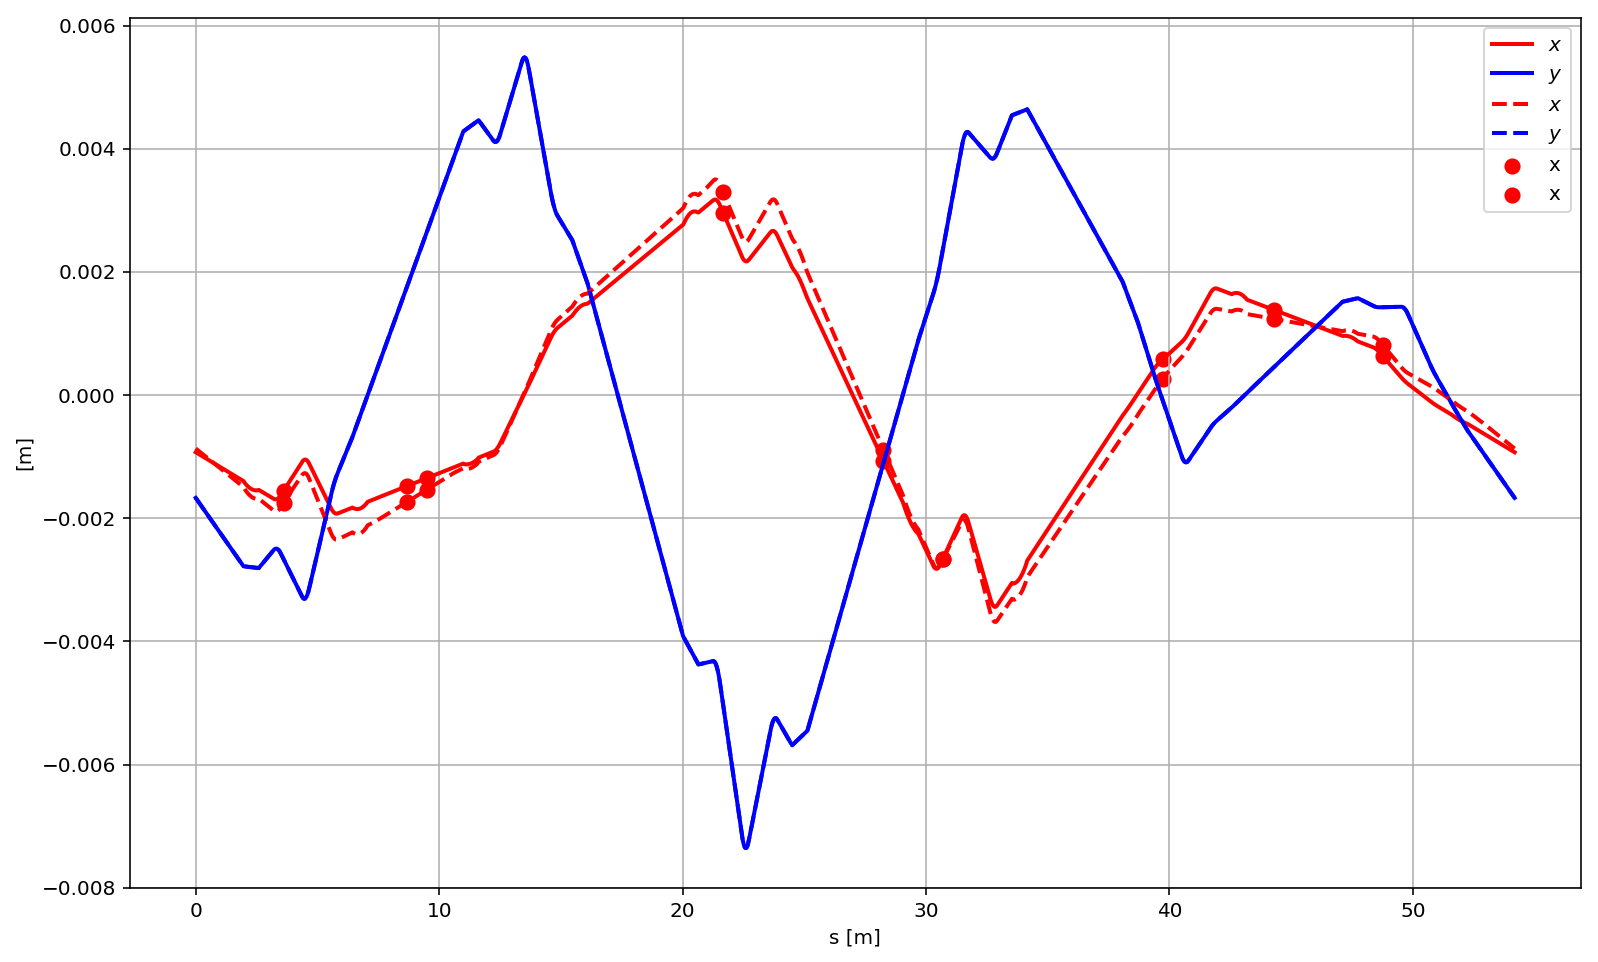

In [112]:
fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='$x$', lw=2)
plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50)

plt.plot(DF['s'],DF['x'],'r',ls="--", label='$x$', lw=2)
plt.plot(DF['s'],DF['y'],'b',ls="--", label='$y$', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50)

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()


In [48]:
theta0 = np.random.normal(0,0.0001,9)
#theta0 = np.zeros(9)
#vec = ls(find_gradient,theta0)
vec = ls(func,theta0)
print(vec.x)

metric = 0.00023405928246593723
metric = 0.00023405758694269044
metric = 0.0002340586335492586
metric = 0.00023406101615484407
metric = 0.00023405672050048806
metric = 0.00023405537842137615
metric = 0.0002340636479408537
metric = 0.00023406297572295496
metric = 0.00023406154390977871
metric = 0.00023405755174003628
metric = 5.0904220822368006e-05
metric = 5.090247103407325e-05
metric = 5.090357212389182e-05
metric = 5.090243974398529e-05
metric = 5.0901593782178516e-05
metric = 5.090036399849637e-05
metric = 5.090002299284505e-05
metric = 5.090777297657323e-05
metric = 5.090644794887979e-05
metric = 5.09025743013178e-05
metric = 2.209488550767241e-06
metric = 2.2089340184913834e-06
metric = 2.2090355695301114e-06
metric = 2.2096380810933366e-06
metric = 2.209438507283384e-06
metric = 2.20929392850293e-06
metric = 2.209670603684823e-06
metric = 2.2096051231266306e-06
metric = 2.210022030004061e-06
metric = 2.2093121119932683e-06
metric = 4.048951116268204e-06
metric = 3.852555049880801

metric = 2.2099116072221023e-06
metric = 2.210264952895498e-06
metric = 2.210517942453144e-06
metric = 2.2090517224219797e-06
metric = 2.2099925627912977e-06
metric = 2.2095866944583264e-06
metric = 2.2099107337421233e-06
metric = 2.209595514342976e-06
metric = 2.209734507983501e-06
metric = 2.210366153009816e-06
metric = 2.209904625427003e-06
metric = 2.210257971100203e-06
metric = 2.2105109606577124e-06
metric = 2.2090447406258824e-06
metric = 2.209985580995958e-06
metric = 2.2095797126623515e-06
metric = 2.2099041214894138e-06
metric = 2.20958853254753e-06
metric = 2.2097327631805783e-06
metric = 2.210364408207107e-06
metric = 2.2099028806242744e-06
metric = 2.2102562262971587e-06
metric = 2.2105092158551203e-06
metric = 2.2090429958233395e-06
metric = 2.2099838361930806e-06
metric = 2.2095779678591364e-06
metric = 2.2099024708583536e-06
metric = 2.2095867877450066e-06
metric = 2.2097323270239264e-06
metric = 2.210363972050393e-06
metric = 2.209902444467641e-06
metric = 2.2102557901